In [1]:
import sys
sys.path.append('/../QmeQ/qmeq/')
#sys.path.append('../qmeq/')
import qmeq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#--SETUP: ---------------------------------------------------------------------------------
epsilons = np.linspace(300, 600, 10)
omega = 200
cb = 2000
V_B = 100
mu_L = -V_B/2       
mu_R = V_B/2        

gammaL = 0.5
gammaR = gammaL
tL = np.sqrt(gammaL/np.pi/2)
tR = np.sqrt(gammaR/np.pi/2)
T_L = 200
T_R = 1
n = 4
nleads = 4

U = {(0,1,1,0):cb, (2,3,3,2):cb } #Jag har antagit här bara CR mellan nivåer i samma QD, men måste dubbelchecka!
mulst = {0:mu_L, 1:mu_L, 2:mu_R, 3:mu_R}
tlst = {0:T_L, 1:T_L, 2:T_R, 3:T_R}

In [3]:
#Från series till parallel!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#series: omega = 1, tL* = 0
#parallel: omega = 0, tL* = 1
#lmda : 0 -> 1
lamdas = np.linspace(0,1,12)
I = np.zeros((len(lamdas),len(epsilons)))
I_var = np.zeros((len(lamdas),len(epsilons)))
J_QH = np.zeros((len(lamdas),len(epsilons)))

#system = qmeq.Builder(nsingle=n, coulomb=U, nleads=nleads,
                        #mulst=mulst, tlst=tlst, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')


for l_idx, lmda in enumerate(lamdas):
    for e_idx, eps in enumerate(epsilons):
        #system.change(hsingle={(0,0):eps, (1,1):eps, (2,2):eps, (3,3):eps, (0,2):(1-lmda)*omega, (1,3):(1-lmda)*omega})
        #system.change(tleads={(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):lmda*tL, (1,3):lmda*tL, (2,0):lmda*tR, (3,1):lmda*tR})
        system = qmeq.Builder(nsingle=n, hsingle={(0,0):eps, (1,1):eps, (2,2):eps, (3,3):eps, (0,2):(1-lmda)*omega, (1,3):(1-lmda)*omega}, coulomb=U, nleads=nleads,
                        mulst=mulst, tlst=tlst, tleads={(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):lmda*tL, (1,3):lmda*tL,
                        (2,0):lmda*tR, (3,1):lmda*tR}, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
        system.solve()
        if system.current_noise[1] < 0:
            print(system.current_noise[1])
        I[l_idx, e_idx] = system.current_noise[0]
        I_var[l_idx, e_idx] = system.current_noise[1]
        J_QH[l_idx, e_idx] = system.heat_current[0]


In [4]:
#Calculations of P, efficiency, sigma and TUR
if T_L < T_R:
    T_COLD = T_L
    T_HOT = T_R
elif T_L > T_R:
    T_COLD = T_R
    T_HOT = T_L
elif T_L == T_R:
    raise SystemExit("Not a heat engine (T_L = T_R) so cell was shut down")

P = I*V_B
eff_carnot = 1-(T_COLD/T_HOT)
eff = P/J_QH
sigma = P*(1/T_COLD)*(eff_carnot-eff)/eff
TUR = I_var*sigma/(I**2)

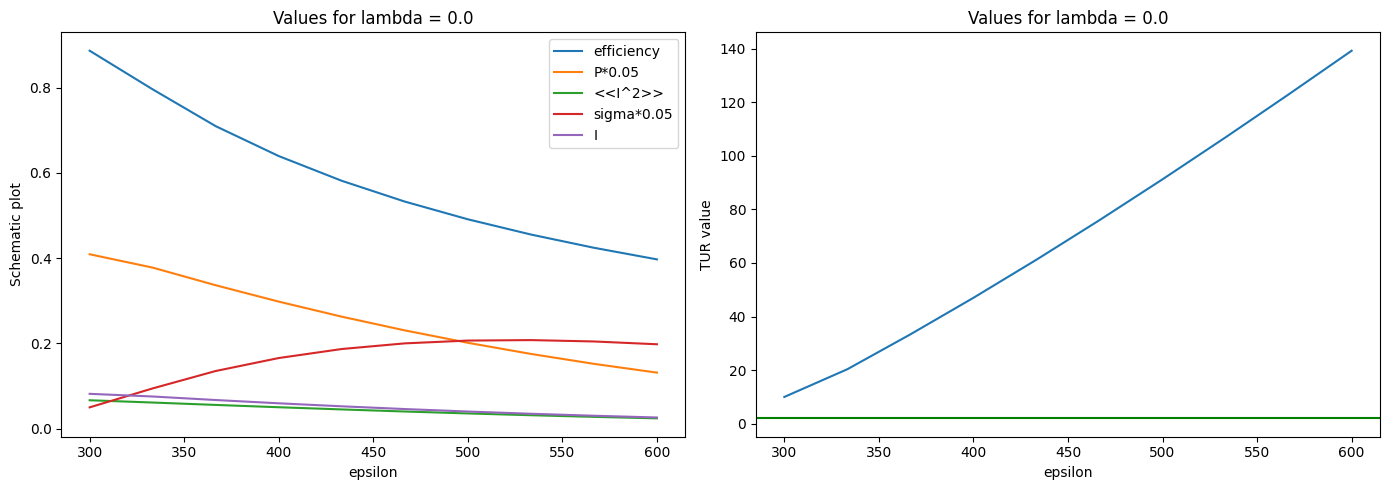

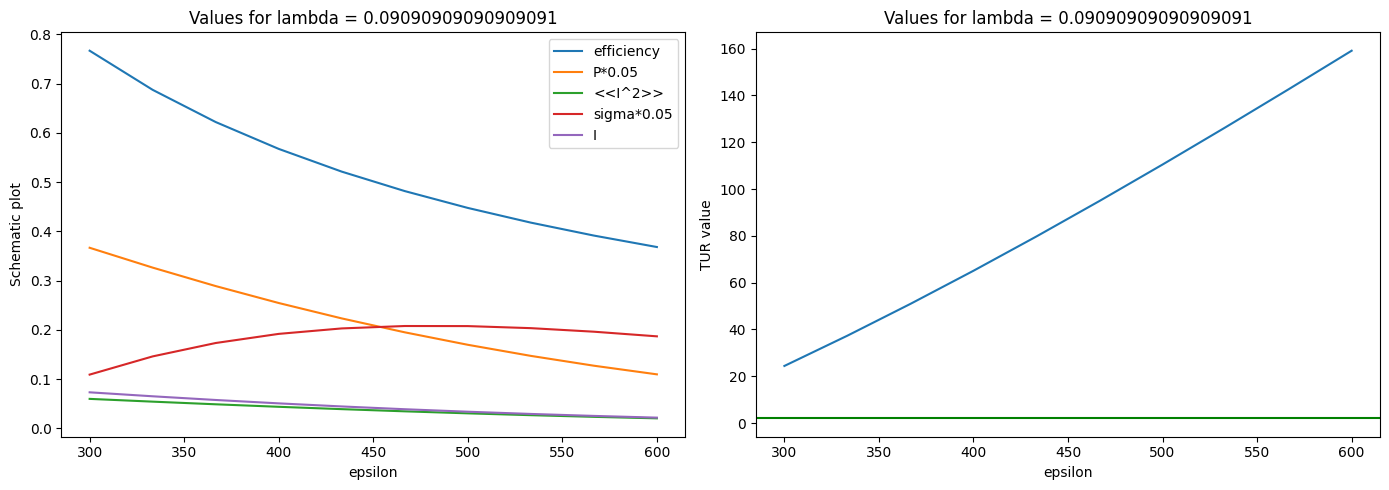

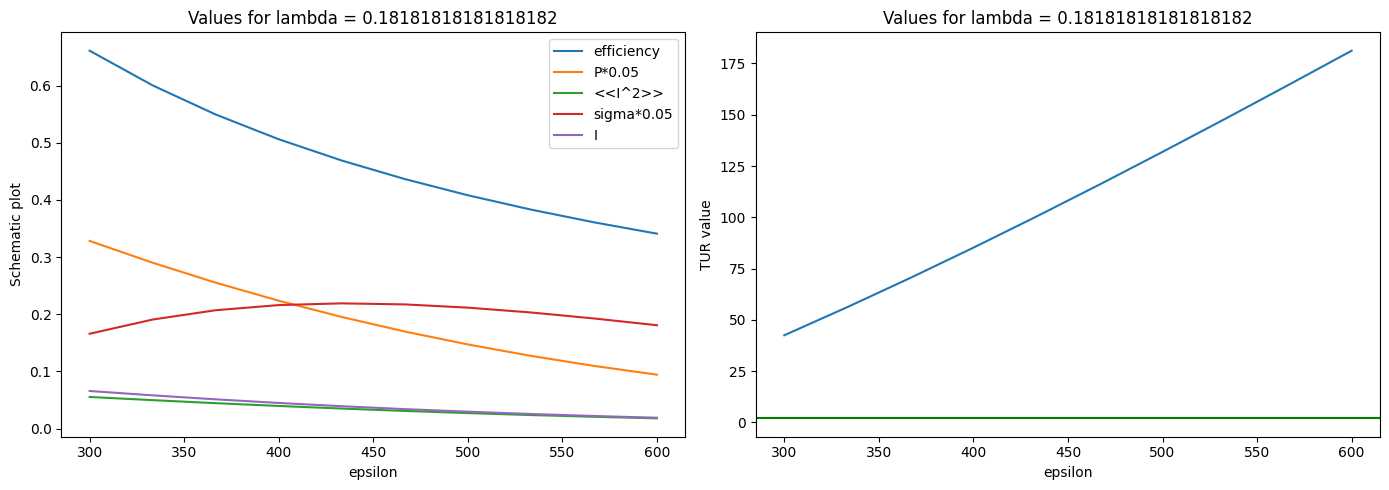

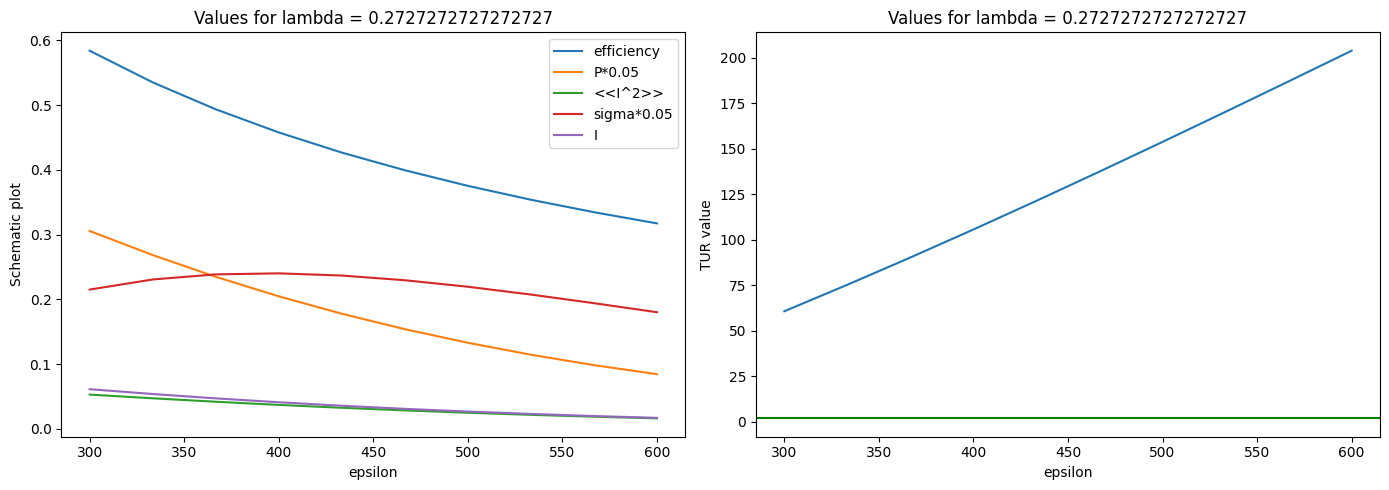

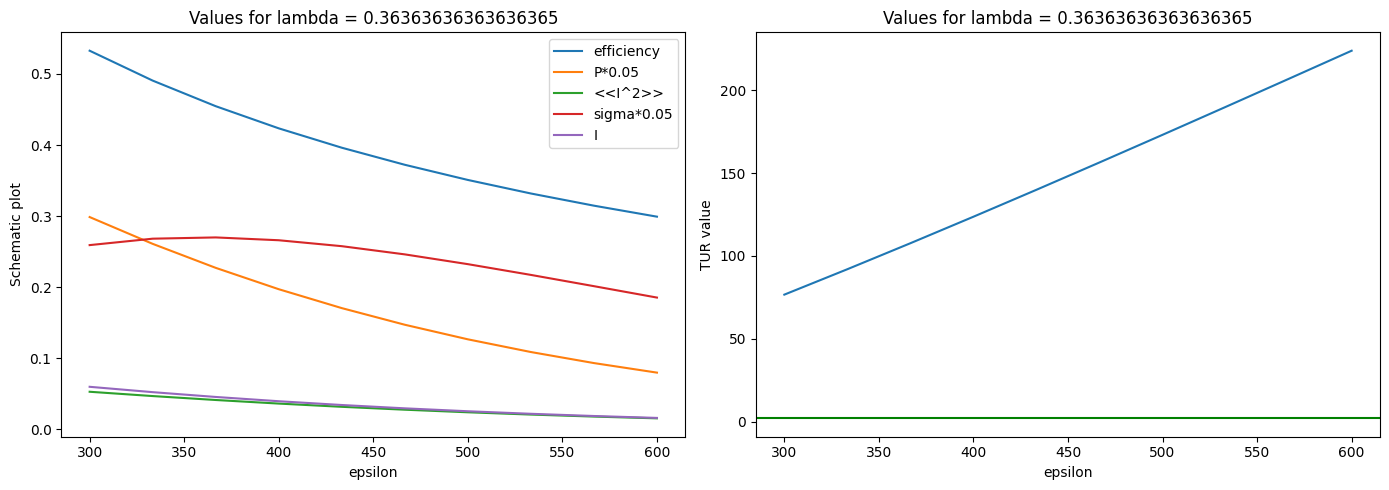

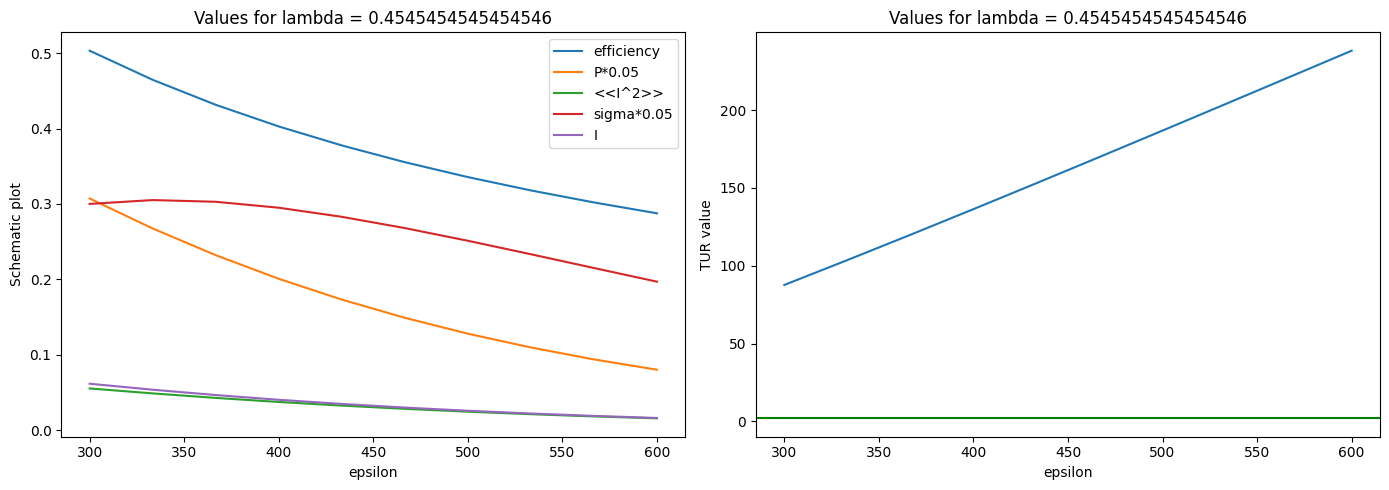

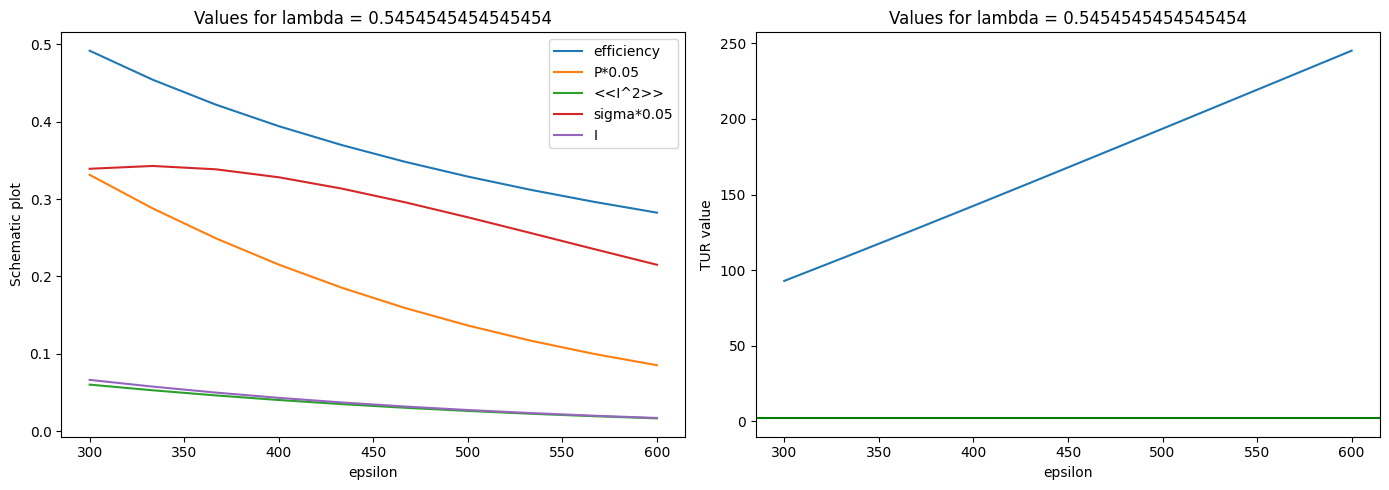

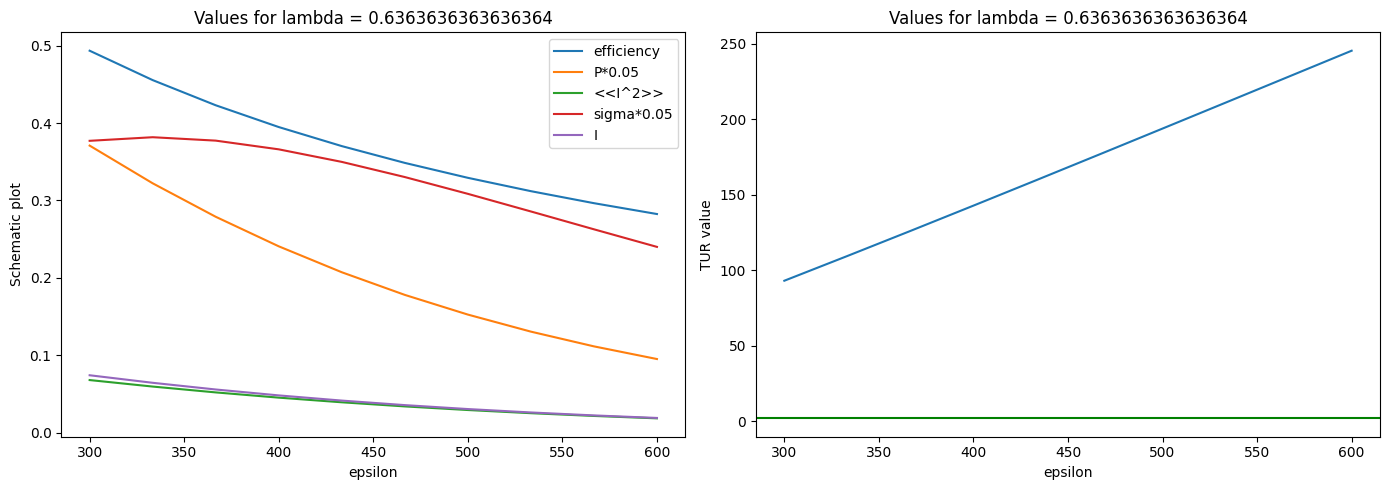

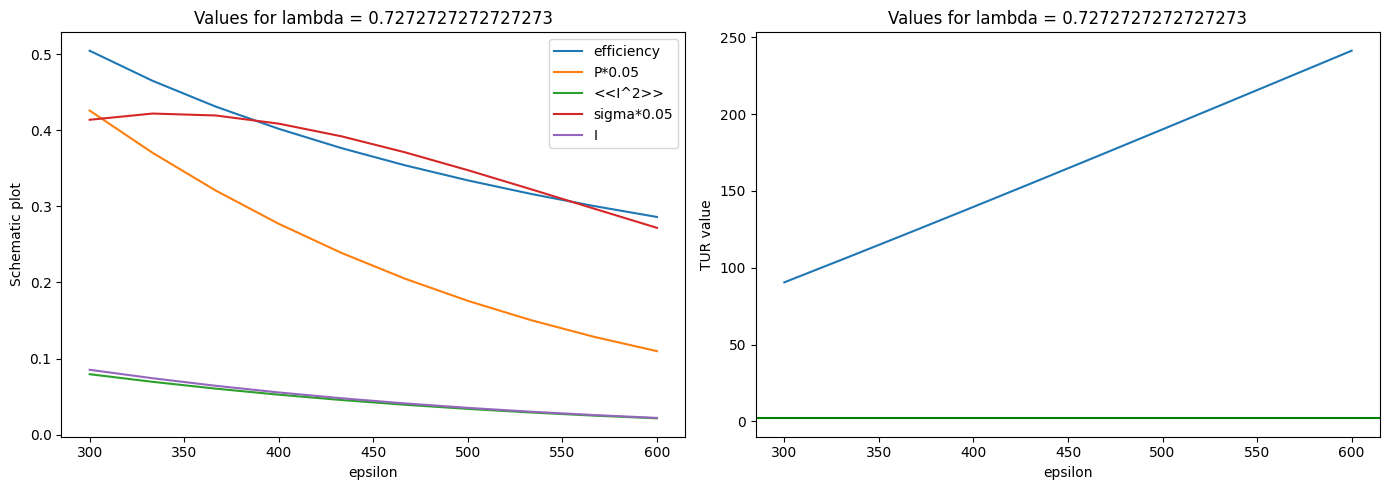

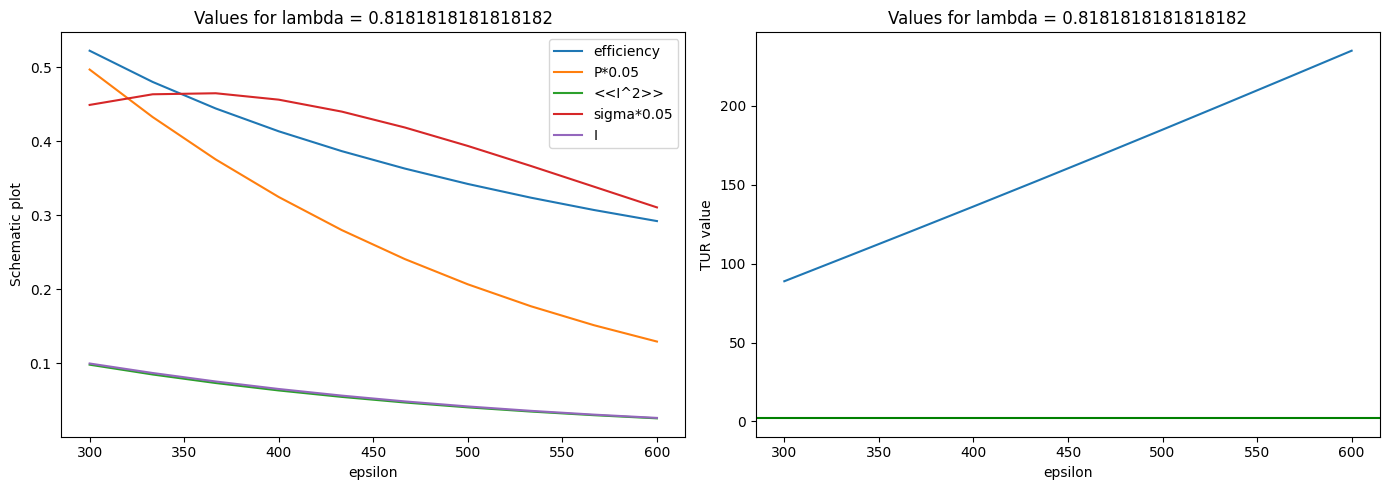

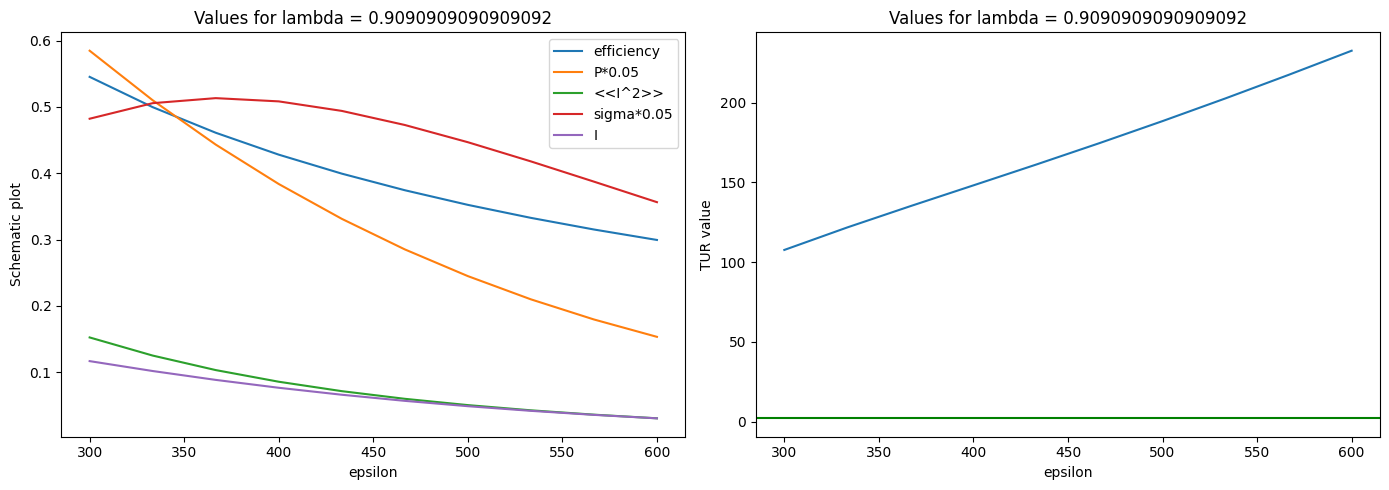

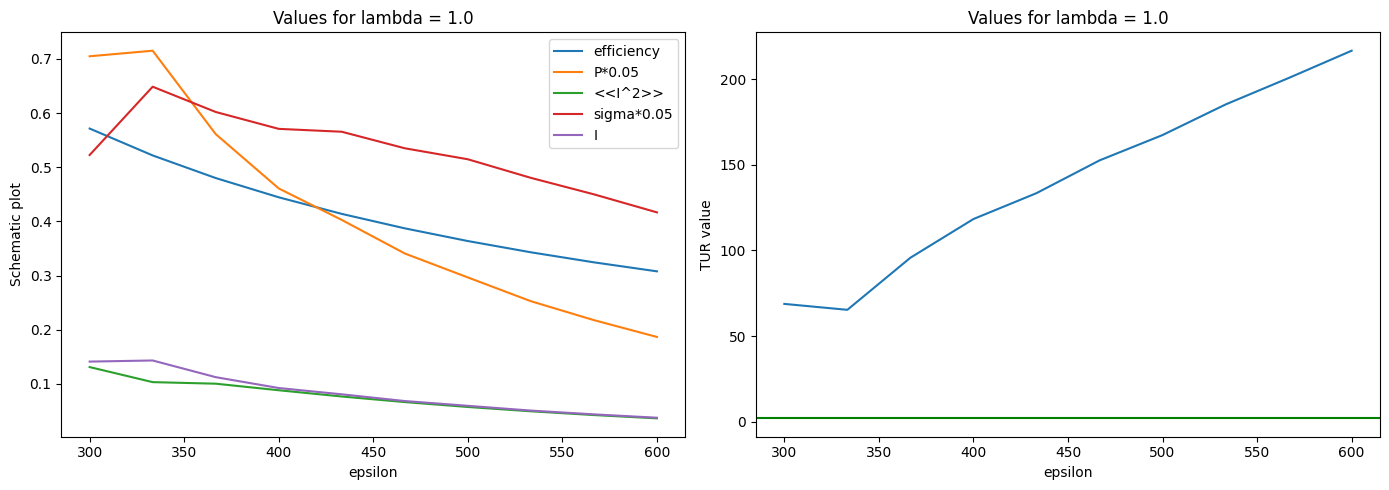

In [9]:
#---------plotting----------------------------------
for idx, lmda in enumerate(lamdas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 

    ax1.plot(epsilons, eff[idx], label='efficiency')
    ax1.plot(epsilons, 0.05*P[idx], label='P*0.05')
    ax1.plot(epsilons, I_var[idx], label='<<I^2>>')
    ax1.plot(epsilons, 0.05*sigma[idx], label='sigma*0.05')
    ax1.plot(epsilons, I[idx], label='I')
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('Schematic plot')
    ax1.set_title(f'Values for lambda = {lmda}')
    ax1.legend()

    ax2.plot(epsilons, TUR[idx], label='TUR')
    ax2.set_title(f'Values for lambda = {lmda}')
    ax2.axhline(y=2, color='g', linestyle='-', label= 'Y = 2')
    ax2.set_xlabel('epsilon')
    ax2.set_ylabel('TUR value')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

I: (12, 10)
meshgrid:
epsilon: (12, 10)
lamda: (12, 10)


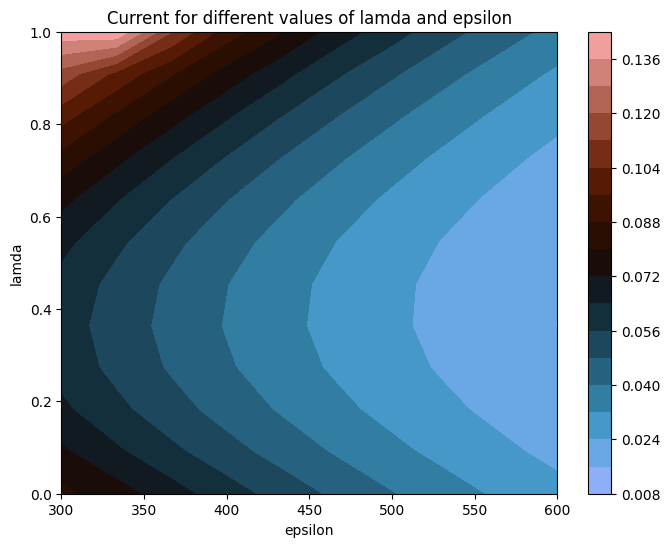

In [6]:
# Plotting of the cummulants

# Create a mesh grid
epsilon, lamda = np.meshgrid(epsilons, lamdas)
print('I:',I.shape)
print('meshgrid:')
print('epsilon:', epsilon.shape)
print('lamda:', lamda.shape)

plt.figure(figsize=(8, 6))
# Create a contour plot (or a pcolormesh plot for a smooth color gradient)
contour = plt.contourf(epsilon, lamda, I, 20, cmap='berlin')  # Adjust number of contour levels as needed
#contour = plt.pcolormesh(epsilon, lamda, I, shading='auto', cmap='viridis')
plt.colorbar(contour)
plt.xlabel('epsilon')
plt.ylabel('lamda')
plt.title('Current for different values of lamda and epsilon')
plt.show()

In [7]:
eps = 500
#double QD in series (with spin) ==============================================================================================================
h = {(0,0):eps, (1,1):eps, (2,2):eps, (3,3):eps, (0,2):omega, (1,3):omega} # <-------/// Här skiljer dom sig ! ///----
tleads = {(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR} # <------/// Här skiljer dom sig ! ///----

system_parallell = qmeq.Builder(nsingle=n, hsingle=h, coulomb=U, nleads=nleads,
                         mulst=mulst, tlst=tlst, tleads=tleads, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
system_parallell.solve()
print('IN SERIES: Standard current:',system_parallell.current)
print('IN SERIES: Counting currents and noise at the left lead (Lindblad):',system_parallell.current_noise)

#double QD in parallel (with spin) ===========================================================================================================
h = {(0,0):eps, (1,1):eps, (2,2):eps, (3,3):eps} # <------/// Här skiljer dom sig ! ///-----
tleads = {(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):tL, (1,3):tL, (2,0):tR, (3,1):tR} # <-------/// Här skiljer dom sig ! ///----
#============================================================================================================================================

system_parallell = qmeq.Builder(nsingle=n, hsingle=h, coulomb=U, nleads=nleads,
                         mulst=mulst, tlst=tlst, tleads=tleads, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
system_parallell.solve()
print('IN PARALLEL: Standard current:',system_parallell.current)
print('IN PARALLEL: Counting currents and noise at the left lead (Lindblad):',system_parallell.current_noise)

IN SERIES: Standard current: [ 0.02015077  0.02015077 -0.02015077 -0.02015077]
IN SERIES: Counting currents and noise at the left lead (Lindblad): [0.04030154 0.03584164]
IN PARALLEL: Standard current: [ 0.02964349  0.02964349 -0.02964349 -0.02964349]
IN PARALLEL: Counting currents and noise at the left lead (Lindblad): [0.05928699 0.05715644]
